In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import warnings

Чтобы сдать задание, выполните следующую последовательность действий.

1. Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). **Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!**

In [2]:
from os import listdir
from os.path import isfile, join
import re

files = [f for f in listdir('.') if isfile(join('.', f)) and f.startswith('time_region')]

data = []

for file in files:
    date = re.split('_|\.', file)[-2]
    if date == '2016-06' or date == '2016-05':
        continue
    time_reg = pd.read_csv('time_region_' + date + '.csv', index_col='tpep_pickup_datetime')
    data.append(time_reg)

names_of_regions = pd.read_csv('big_regions.csv').astype(str).values.reshape(-1)
data = pd.concat(data)
data = data[names_of_regions]

2. Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.

In [3]:
data = (data - data.mean()) / data.std()
data = data.T

3. Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.

Здесь используем обычный KNN, но только параметр K будем подбирать по методу Elbow. То есть выберем такое число, при котором происходит сильное "преломление"

In [4]:
Ks = range(1, 100)
km = [KMeans(n_clusters=i, random_state=0) for i in Ks]
score = [km[i].fit(data.values).score(data.values) for i in range(len(km))]

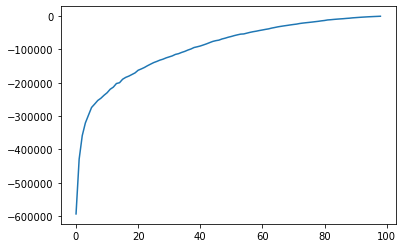

In [5]:
plt.plot(score)

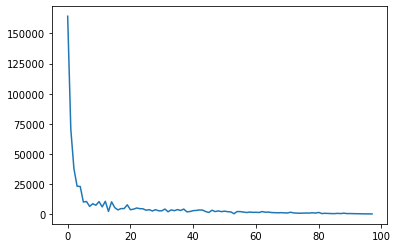

In [6]:
plt.plot(np.diff(score))

Выбираем K равным 7

In [7]:
kmeans = KMeans(n_clusters=7, random_state=0, max_iter=1000)
kmeans.fit(data.values);

Посмотрим на кластеры, которые получились в итоге. В целом, получились очень похожие друг на друга

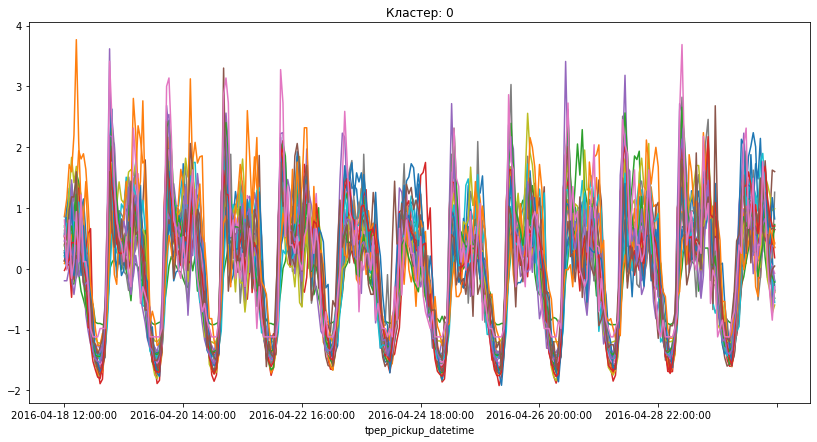

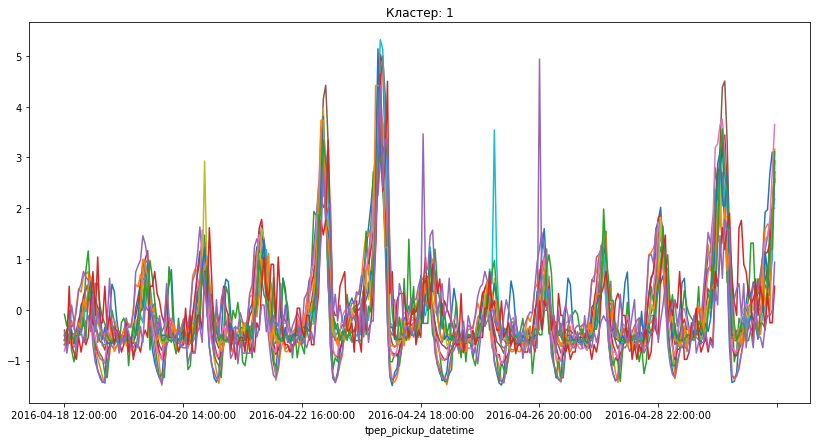

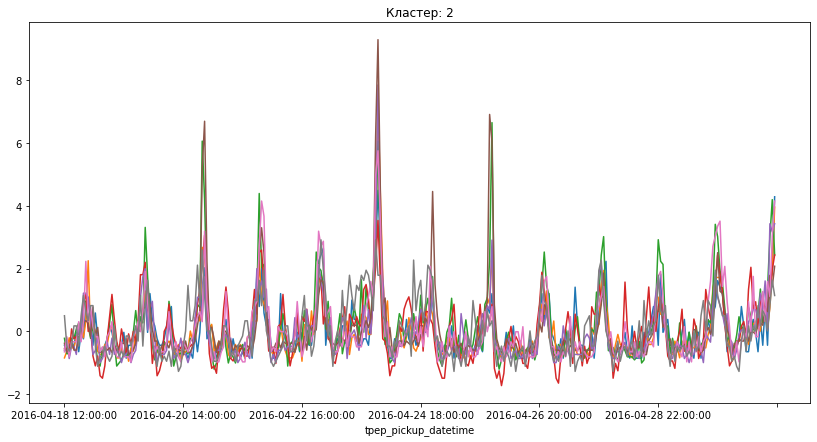

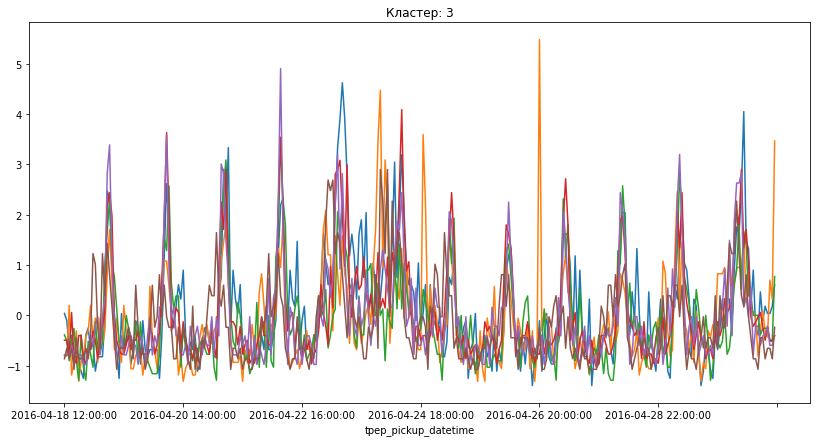

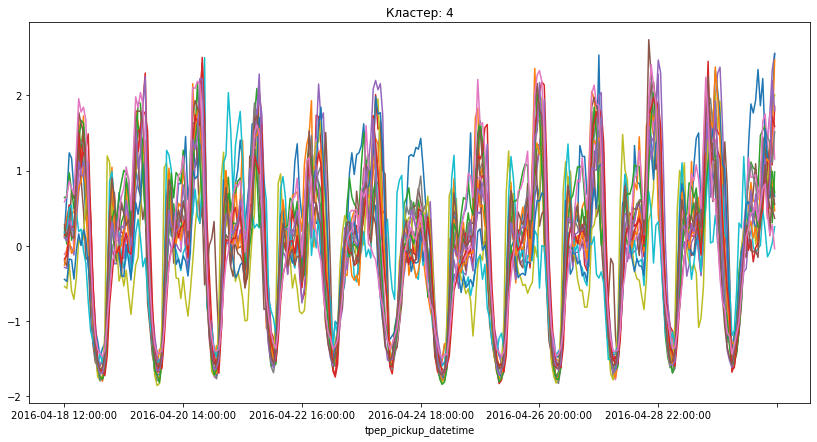

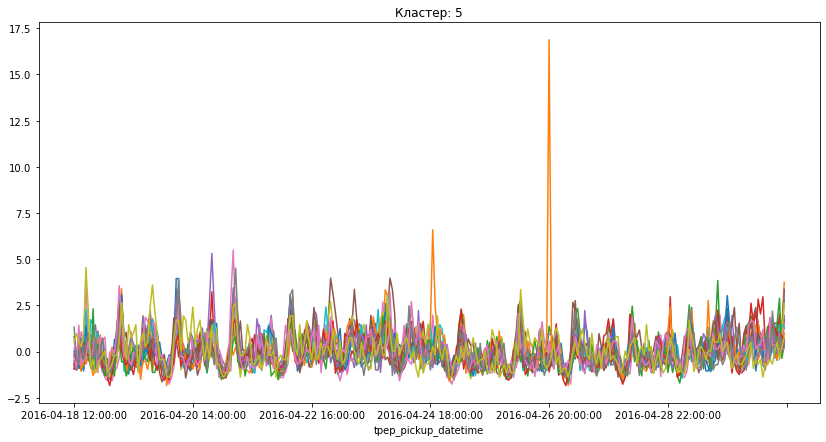

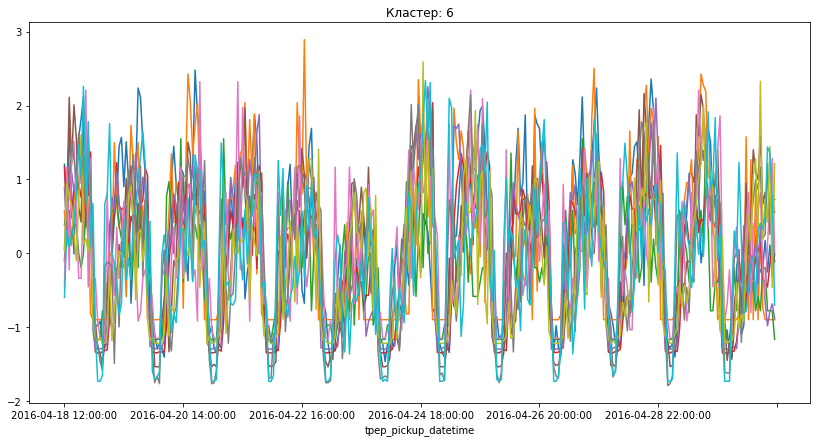

In [8]:
for label in np.unique(kmeans.labels_):
    plt.figure(figsize=(14, 7))
    for index in data.iloc[kmeans.labels_ == label].index:
        data.loc[index].iloc[-300:].plot()
    plt.title('Кластер: ' + str(label))
    plt.show()

4. В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).

За типичный ряд мы возьмем центр масс каждого кластера

In [9]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=data.columns)

5. Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров $p,d,q,P,D,Q$ — так, как это делалось на прошлой неделе. **Не используйте данные за последний имеющийся месяц — май и июнь 2016!**

Признаюсь, что здесь я немного схалтурил и вместо ручного подбора гиперпараметров для Аримы, я просто запустил более долгий перебор по всем комбинациям. Да, это заняло больше времени, но зато сэкономило силы, да и в будущем можно вместо настройки аримы посмотреть в сторону более современных методов работы с временными рядами, такие как Prophet от Facebook или нейронные сети

In [32]:
ps = range(0, 2)
d=0
qs = range(0, 5)
Ps = range(0, 7)
D=1
Qs = range(0, 2)

from itertools import product
parameters_list = list(product(ps, qs, Ps, Qs))
warnings.filterwarnings('ignore')

def build_model(y):
    mse_list = []
    N = 50 
    K = 250
    row = np.arange(1, y.shape[0]+1)

    for number in range(N, K+1):
        X = pd.DataFrame(row, index=y.index, columns=['s_0'])
        for i in range(1, number+1):
            X['s_year_'+str(i)] = np.sin(row*2*np.pi*i/8766)
            X['c_year_'+str(i)] = np.cos(row*2*np.pi*i/8766)
            X['s_week_'+str(i)] = np.sin(row*2*np.pi*i/168)
            X['c_week_'+str(i)] = np.cos(row*2*np.pi*i/168)
        model = LinearRegression()
        res = model.fit(X, y)
        mse_list.append(mean_squared_error(y, res.predict(X)))
    X = X[:'c_week_'+str(np.argmin(mse_list))]
    
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred = linear_model.predict(X['2016-04-01':])
    
    resid_for_arima = pd.DataFrame(y['2016-04-01':] - y_pred)
    
    best_aic = float("inf")
    for param in parameters_list:
        try:
            arima_model=sm.tsa.statespace.SARIMAX(resid_for_arima,  order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1, maxiter=10)
        except ValueError:
            continue
        aic = arima_model.aic
        if aic < best_aic:
            best_arima_model = arima_model
            best_aic = aic
            best_param = param
    
    return X.columns, linear_model, best_arima_model

К каждому типичному ряду применим тот же алгоритм построения моделей, что и на прошлой неделе и сохраним полученные модели

In [15]:
models = centroids.apply(build_model, axis=1)

6. Для каждой из $R$ географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу:

$$
Q_{may}=\frac{1}{R*739*6}\sum_{r=1}^{R}{\sum_{T=2016.04.30\ 23:00}^{2016.05.31\ 17:00}{\sum_{i=1}^{6}{|\hat{y}^r_{T|T+i} - y^r_{T+i}|}}}
$$

Сделаем прогноз по указанному интервалу. Здесь мы в основном строим заново признаки, так как модели уже готовы и предиктим в пару строчек

In [260]:
predict_date = pd.date_range(start='2016-04-30 23:00:00',end='2016-05-31 17:00:00', freq='H')
predict_row = np.arange(predict_date.shape[0])

def predict(label):
    X = pd.DataFrame(predict_row, index=predict_date, columns=['s_0'])
    for i in range(1, (models[label][0].coef_.shape[0] - 1)//4 + 1):
        X['s_year_'+str(i)] = np.sin(predict_row*2*np.pi*i/8766)
        X['c_year_'+str(i)] = np.cos(predict_row*2*np.pi*i/8766)
        X['s_week_'+str(i)] = np.sin(predict_row*2*np.pi*i/168)
        X['c_week_'+str(i)] = np.cos(predict_row*2*np.pi*i/168)
        
    linreg_pred = models[label][0].predict(X)
    arima_pred = models[label][1].predict(start=predict_date[0], end=predict_date[-1])
    
    return linreg_pred + arima_pred

predictions = [predict(label) for label in sorted(np.unique(kmeans.labels_))]

In [261]:
predictions = pd.merge(
    pd.Series(kmeans.labels_, name='label'), 
    pd.DataFrame(predictions),
    left_on='label', right_index=True
).drop('label', axis=1).sort_index()
predictions.index = data.index

In [262]:
predictions.head()

,2016-04-30 23:00:00,2016-05-01 00:00:00,2016-05-01 01:00:00,2016-05-01 02:00:00,2016-05-01 03:00:00,2016-05-01 04:00:00,2016-05-01 05:00:00,2016-05-01 06:00:00,2016-05-01 07:00:00,2016-05-01 08:00:00,...,2016-05-31 08:00:00,2016-05-31 09:00:00,2016-05-31 10:00:00,2016-05-31 11:00:00,2016-05-31 12:00:00,2016-05-31 13:00:00,2016-05-31 14:00:00,2016-05-31 15:00:00,2016-05-31 16:00:00,2016-05-31 17:00:00
1075,0.985910,0.189791,-0.538044,-1.069035,-1.213455,-1.349664,-1.338818,-0.655625,0.111686,0.519711,...,-0.950917,-0.563984,-0.140716,0.065061,0.242377,0.235676,0.188421,0.149631,-0.005659,0.128662
1076,-0.287355,-0.906415,-1.085111,-1.370316,-1.331357,-1.297347,-1.007359,-0.034241,1.353343,1.609027,...,-0.206012,0.293470,0.725293,0.791841,0.947940,0.882962,0.853790,0.764908,0.578934,0.637590
1077,-0.287355,-0.906415,-1.085111,-1.370316,-1.331357,-1.297347,-1.007359,-0.034241,1.353343,1.609027,...,-0.206012,0.293470,0.725293,0.791841,0.947940,0.882962,0.853790,0.764908,0.578934,0.637590
1125,0.985910,0.189791,-0.538044,-1.069035,-1.213455,-1.349664,-1.338818,-0.655625,0.111686,0.519711,...,-0.950917,-0.563984,-0.140716,0.065061,0.242377,0.235676,0.188421,0.149631,-0.005659,0.128662
1126,0.985910,0.189791,-0.538044,-1.069035,-1.213455,-1.349664,-1.338818,-0.655625,0.111686,0.519711,...,-0.950917,-0.563984,-0.140716,0.065061,0.242377,0.235676,0.188421,0.149631,-0.005659,0.128662


Так как при изменении исходных данных я забыл сохранить значения средних и дисперсии, то заново загрузим данные :)

Заодно загрузим тестовые месяца

In [253]:
from os import listdir
from os.path import isfile, join
import re

files = [f for f in listdir('.') if isfile(join('.', f)) and f.startswith('time_region')]

data_orig = []

for file in files:
    date = re.split('_|\.', file)[-2]
    if date == '2016-06' or date == '2016-05':
        continue
    time_reg = pd.read_csv('time_region_' + date + '.csv', index_col='tpep_pickup_datetime')
    data_orig.append(time_reg)
    
names_of_regions = pd.read_csv('big_regions.csv').astype(str).values.reshape(-1)
data_orig = pd.concat(data_orig)
data_orig = data_orig[names_of_regions].T

may = []
for file in files:
    date = re.split('_|\.', file)[-2]
    if date != '2016-05':
        continue
    time_reg = pd.read_csv('time_region_' + date + '.csv', index_col='tpep_pickup_datetime')
    may.append(time_reg)
    
may = pd.concat(may)
may = may[names_of_regions].T

june = []
for file in files:
    date = re.split('_|\.', file)[-2]
    if date != '2016-06':
        continue
    time_reg = pd.read_csv('time_region_' + date + '.csv', index_col='tpep_pickup_datetime')
    june.append(time_reg)
    
june = pd.concat(june)
june = june[names_of_regions].T

Проводим обратную операцию нормализации

In [263]:
predictions = predictions.multiply(data_orig.std(axis=1), axis=0).add(data_orig.mean(axis=1), axis=0)

Посчитаем ошибку. Используем стандартную фукнцию из sklearn, для этого надо будет оба датафрейма привести к одному виду

In [309]:
for_six = data_orig[['2016-04-30 23:00:00']].merge(may.loc[:, :'2016-05-31 17:00:00'], left_index=True, right_index=True)
for_six.columns = pd.to_datetime(for_six.columns)

In [310]:
from sklearn.metrics import median_absolute_error

Здесь я посчитал метрику не по той формуле, которая указана в этом задании. Но она абсолютно такая же, как и MAE, так что ничего страшного в этом нет

In [311]:
median_absolute_error(predictions, for_six)

15.369257410117873

7. Для каждой из $R$ географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

Проведем классический пайплайн по прогнозу

In [315]:
predict_date = pd.date_range(start='2016-05-31 23:00:00',end='2016-06-30 17:00:00', freq='H')
predict_row = np.arange(predict_date.shape[0])

predictions_june = [predict(label) for label in sorted(np.unique(kmeans.labels_))]

predictions_june = pd.merge(
    pd.Series(kmeans.labels_, name='label'), 
    pd.DataFrame(predictions_june),
    left_on='label', right_index=True
).drop('label', axis=1).sort_index()
predictions_june.index = data.index

predictions_june = predictions_june.multiply(data_orig.std(axis=1), axis=0).add(data_orig.mean(axis=1), axis=0)

В publishing мы будем сохранять результаты

In [390]:
publishing = pd.DataFrame(columns=['id', 'y'])
publishing.set_index('id', inplace=True)

In [418]:
stacking = predictions_june.stack().reset_index()

In [428]:
stacking[0]

0        105.421021
1         73.487055
2         42.983129
3         21.366021
4         14.991949
            ...    
72925     72.233151
72926     74.013263
72927     78.089325
72928     74.866594
72929     83.617136
Name: 0, Length: 72930, dtype: float64

In [429]:
pd.DataFrame(stacking[0].values, index=stacking['level_0'] + \
    '_' + stacking['level_1'].dt.year.astype(str) + \
    '-'+ stacking['level_1'].dt.month.astype(str) + \
    '-' + stacking['level_1'].dt.day.astype(str) + \
    '_' + stacking['level_1'].dt.hour.astype(str) + \
    '_' + str(i))

,0
1075_2016-5-31_23_6,105.421021
1075_2016-6-1_0_6,73.487055
1075_2016-6-1_1_6,42.983129
1075_2016-6-1_2_6,21.366021
1075_2016-6-1_3_6,14.991949
...,...
2168_2016-6-30_13_6,72.233151
2168_2016-6-30_14_6,74.013263
2168_2016-6-30_15_6,78.089325
2168_2016-6-30_16_6,74.866594


In [457]:
def rewrite_month(date):
    return '0' + str(date.month) if date.month < 10 else str(date.month)

def rewrite_day(date):
    return '0' + str(date.day) if date.day < 10 else str(date.day)

In [458]:
reg_date = stacking['level_0'] + \
        '_' + stacking['level_1'].dt.year.astype(str) + \
        '-'+ stacking['level_1'].apply(rewrite_month) + \
        '-' + stacking['level_1'].apply(rewrite_day) + \
        '_' + stacking['level_1'].dt.hour.astype(str)

In [459]:
def rewrite_month(date):
    return '0' + date.dt.month

ids = []
for i in range(1, 7):
    ids.append(
        pd.DataFrame(stacking[0].values, columns=['y'],
                     index=reg_date + '_' + str(i)).rename_axis('id')
    )

In [460]:
publishing = pd.concat(ids)

In [461]:
publishing.head()

,y
id,
1075_2016-05-31_23_1,105.421021
1075_2016-06-01_0_1,73.487055
1075_2016-06-01_1_1,42.983129
1075_2016-06-01_2_1,21.366021
1075_2016-06-01_3_1,14.991949


8. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

In [466]:
publishing.to_csv('to_kaggle.csv')

Score 80.22672

9. Загрузите ноутбук в форму.

Done